In [129]:
import pandas as pd
import numpy as np
import json
import pickle
import matplotlib.pyplot as plt

In [130]:
with open('intermediate_file_paths.json') as output_path_file:
    output_paths = json.load(output_path_file)

SI_PER_FIRE_INPUT_PATH = output_paths.get('stage1_si_per_fire_csv')

NORM_WT_FTRS_INPUT_PATH = output_paths.get('normalize_and_weight_features.csv')

MODEL_INPUT_PATH = output_paths.get("model_output")

FUTURE_PREDS_OUTPUT_PATH = output_paths.get("smoke_impact_model_predictions.csv")

## Future Predictions for Fire Size and Distance from Memphis 

This code processes historical fire data to calculate a 5-year rolling average of total acres burned and average distance, which is used as the basis for future predictions from 2025 to 2050. For each 5-year interval, the most recent rolling average is applied, and then the new data is incorporated into the dataset to update the rolling average, simulating trends over time. The output provides year-by-year predictions that adjust every 5 years based on historical patterns.

In [131]:
fire_data = pd.read_csv(SI_PER_FIRE_INPUT_PATH)

In [132]:
# Group by year and calculate sums and averages for fire size and distance
yearly_fire_data = fire_data.groupby('fire_year').agg(
    total_acres_burned_sum=('total_acres_burned', 'sum'),
    avg_distance=('distance', 'mean')
).reset_index()

# Sort by year for chronological order
yearly_fire_data = yearly_fire_data.sort_values(by='fire_year')

# %%
print(yearly_fire_data)

    fire_year  total_acres_burned_sum  avg_distance
0        1964            2.846812e+01    384.142162
1        1965            4.378149e+01    371.279426
2        1966            2.696491e+01    260.843100
3        1967            5.048215e+02    371.508724
4        1968            4.072332e+01    363.429542
5        1969            3.952557e+02    285.092861
6        1970            2.350625e+03    210.041483
7        1971            1.114742e+03    207.752459
8        1972            5.916350e+02    219.768587
9        1973            3.328419e+02    213.031734
10       1974            1.370488e+03    244.264814
11       1975            1.064286e+03    245.898506
12       1976            4.254954e+03    267.141995
13       1977            2.231838e+03    263.460774
14       1978            4.031375e+03    321.191568
15       1979            2.274603e+03    328.034550
16       1980            4.400419e+03    337.184409
17       1981            4.243582e+03    379.948317
18       198

In [133]:
# Filter data to include only years after 1984
filtered_yearly_fire_data = yearly_fire_data[yearly_fire_data['fire_year'] > 1984]

# Normalize the historical data before calculating rolling averages
max_distance = 650

# Read the CSV file
df = pd.read_csv(NORM_WT_FTRS_INPUT_PATH)


# Set the variables from the DataFrame values
acres_weight = df.at[0, "acres_weight"]
dist_weight = df.at[0, "dist_weight"]
max_acres_burned = df.at[0, "max_total_acres_burned"]

# Convert to the appropriate data type if needed
acres_weight = float(acres_weight)
dist_weight = float(dist_weight)
max_acres_burned = float(max_acres_burned)


print(f'max_acres_burned: {max_acres_burned}, acres_weight: {acres_weight}, dist_weight: {dist_weight}')

filtered_yearly_fire_data['total_acres_burned_normalized'] = (
    filtered_yearly_fire_data['total_acres_burned_sum'] / max_acres_burned
)
filtered_yearly_fire_data['distance_normalized'] = (
    filtered_yearly_fire_data['avg_distance'] / max_distance
)

max_acres_burned: 4859569.981645179, acres_weight: 1.0, dist_weight: 1.0


/var/folders/js/_m5r698x29j4dvr0w18h6jdm0000gn/T/ipykernel_27853/2297508742.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_yearly_fire_data['total_acres_burned_normalized'] = (
/var/folders/js/_m5r698x29j4dvr0w18h6jdm0000gn/T/ipykernel_27853/2297508742.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_yearly_fire_data['distance_normalized'] = (


In [134]:
print(filtered_yearly_fire_data.columns)

Index(['fire_year', 'total_acres_burned_sum', 'avg_distance',
       'total_acres_burned_normalized', 'distance_normalized'],
      dtype='object')


In [135]:
# Calculate a 5-year moving average for normalized features
filtered_yearly_fire_data['5yr_avg_normalized_acres'] = filtered_yearly_fire_data['total_acres_burned_normalized'].rolling(window=5, min_periods=1).mean()
filtered_yearly_fire_data['5yr_avg_normalized_distance'] = filtered_yearly_fire_data['distance_normalized'].rolling(window=5, min_periods=1).mean()

/var/folders/js/_m5r698x29j4dvr0w18h6jdm0000gn/T/ipykernel_27853/3695203418.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_yearly_fire_data['5yr_avg_normalized_acres'] = filtered_yearly_fire_data['total_acres_burned_normalized'].rolling(window=5, min_periods=1).mean()
/var/folders/js/_m5r698x29j4dvr0w18h6jdm0000gn/T/ipykernel_27853/3695203418.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_yearly_fire_data['5yr_avg_normalized_distance'] = filtered_yearly_fire_data['distance_normal

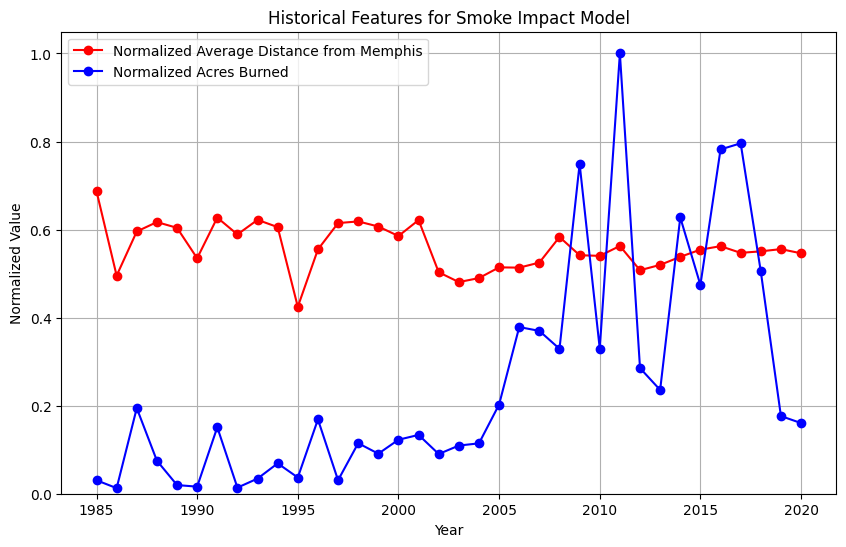

In [136]:
# Plot normalized features
plt.figure(figsize=(10, 6))
plt.plot(filtered_yearly_fire_data['fire_year'], filtered_yearly_fire_data['distance_normalized'], label='Normalized Average Distance from Memphis', linestyle='-', marker='o', color='red')
plt.plot(filtered_yearly_fire_data['fire_year'], filtered_yearly_fire_data['total_acres_burned_normalized'], label='Normalized Acres Burned', linestyle='-', marker='o', color='blue')

# Add titles and labels
plt.title('Historical Features for Smoke Impact Model')
plt.xlabel('Year')
plt.ylabel('Normalized Value')
plt.ylim(0, None)  # Set y-axis to start at 0
plt.grid(True)
plt.legend()
# Display the plot
plt.show()

In [137]:
# Initialize a DataFrame for future predictions
future_years = range(2021, 2051)
future_predictions = pd.DataFrame({
    'year': future_years,
    'predicted_normalized_total_acres_burned': np.nan,
    'predicted_normalized_avg_distance': np.nan
})

# Temporary DataFrame for rolling updates
temp_data = filtered_yearly_fire_data.copy()

# Set the 5-year recalculation cycle
cycle_length = 5

# Simulate rolling average predictions
for i, year in enumerate(future_years):
    # Assign predictions using the latest 5-year averages
    future_predictions.loc[i, 'predicted_normalized_total_acres_burned'] = temp_data['5yr_avg_normalized_acres'].iloc[-1]
    future_predictions.loc[i, 'predicted_normalized_avg_distance'] = temp_data['5yr_avg_normalized_distance'].iloc[-1]

    # Every 5 years, update the rolling averages
    if (i + 1) % cycle_length == 0:
        # Add new normalized predictions as a new "historical" row
        new_row = pd.DataFrame({
            'fire_year': [year],
            'total_acres_burned_normalized': [future_predictions.loc[i, 'predicted_normalized_total_acres_burned']],
            'distance_normalized': [future_predictions.loc[i, 'predicted_normalized_avg_distance']]
        })
        temp_data = pd.concat([temp_data, new_row], ignore_index=True)

        # Update rolling averages
        temp_data['5yr_avg_normalized_acres'] = temp_data['total_acres_burned_normalized'].rolling(window=5, min_periods=1).mean()
        temp_data['5yr_avg_normalized_distance'] = temp_data['distance_normalized'].rolling(window=5, min_periods=1).mean()


# Add weighted features for future predictions
future_predictions['total_acres_burned_weighted'] = future_predictions['predicted_normalized_total_acres_burned'] * acres_weight

future_predictions['distance_weighted'] = future_predictions['predicted_normalized_avg_distance'] * dist_weight

In [138]:
print(future_predictions)
print(future_predictions.columns)

    year  predicted_normalized_total_acres_burned  \
0   2021                                 0.483929   
1   2022                                 0.483929   
2   2023                                 0.483929   
3   2024                                 0.483929   
4   2025                                 0.483929   
5   2026                                 0.424310   
6   2027                                 0.424310   
7   2028                                 0.424310   
8   2029                                 0.424310   
9   2030                                 0.424310   
10  2031                                 0.349993   
11  2032                                 0.349993   
12  2033                                 0.349993   
13  2034                                 0.349993   
14  2035                                 0.349993   
15  2036                                 0.319024   
16  2037                                 0.319024   
17  2038                                 0.319

In [139]:
# Load the trained Gradient Boosting model
with open(MODEL_INPUT_PATH, 'rb') as model_file:
    model = pickle.load(model_file)

# Prepare X_future for model prediction
X_future = future_predictions[['total_acres_burned_weighted', 'distance_weighted']]

# Predict smoke impact for future years
future_predictions['predicted_smoke_impact'] = model.predict(X_future)

# Display updated predictions
print(future_predictions[['year', 'predicted_smoke_impact']])

    year  predicted_smoke_impact
0   2021               34.902199
1   2022               34.902199
2   2023               34.902199
3   2024               34.902199
4   2025               34.902199
5   2026               31.836861
6   2027               31.836861
7   2028               31.836861
8   2029               31.836861
9   2030               31.836861
10  2031               31.836861
11  2032               31.836861
12  2033               31.836861
13  2034               31.836861
14  2035               31.836861
15  2036               31.836861
16  2037               31.836861
17  2038               31.836861
18  2039               31.836861
19  2040               31.836861
20  2041               31.836861
21  2042               31.836861
22  2043               31.836861
23  2044               31.836861
24  2045               31.836861
25  2046               31.836861
26  2047               31.836861
27  2048               31.836861
28  2049               31.836861
29  2050  

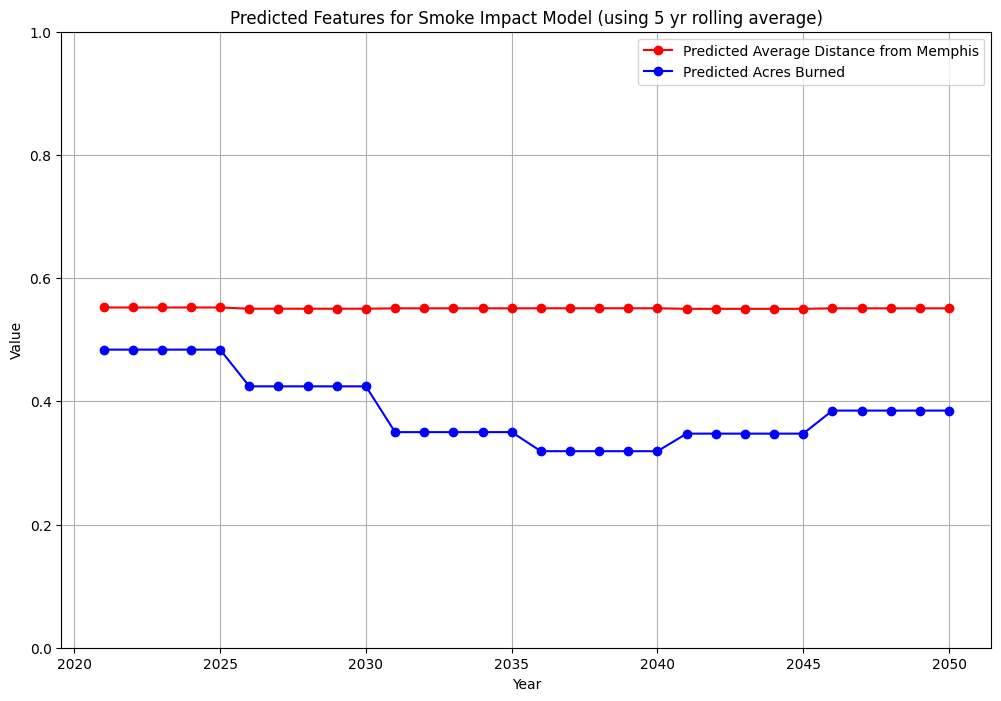

In [140]:
# Create a single plot for all three lines
plt.figure(figsize=(12, 8))

# Plot normalized average distance from Memphis
plt.plot(future_predictions['year'], future_predictions['distance_weighted'], 
         label='Predicted Average Distance from Memphis', linestyle='-', marker='o', color='red')

# Plot normalized total acres burned
plt.plot(future_predictions['year'], future_predictions['total_acres_burned_weighted'], 
         label='Predicted Acres Burned', linestyle='-', marker='o', color='blue')

# Add titles, labels, and grid
plt.title('Predicted Features for Smoke Impact Model (using 5 yr rolling average)')
plt.xlabel('Year')
plt.ylabel('Value')
plt.ylim(0, 1)  # Set y-axis to start at 0
plt.grid(True)
plt.legend()

# Display the plot
plt.show()


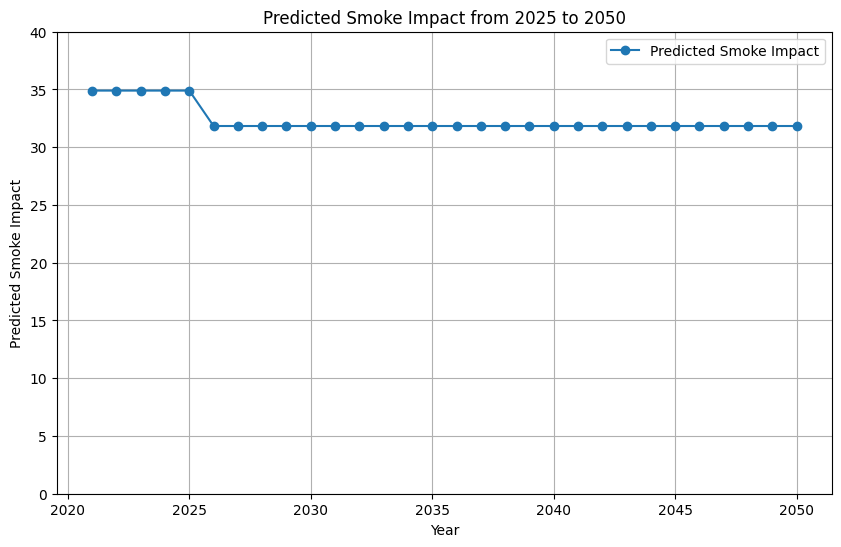

In [141]:
# %%
# Plot predicted smoke impact
plt.figure(figsize=(10, 6))
plt.plot(future_predictions['year'], future_predictions['predicted_smoke_impact'], label='Predicted Smoke Impact', linestyle='-', marker='o')

# Add titles and labels
plt.title('Predicted Smoke Impact from 2025 to 2050')
plt.xlabel('Year')
plt.ylabel('Predicted Smoke Impact')
plt.ylim(0, 40)  # Set y-axis to start at 0
plt.grid(True)
plt.legend()
# Display the plot
plt.show()

In [142]:
# %%
# Save future predictions to CSV
future_predictions.to_csv(FUTURE_PREDS_OUTPUT_PATH, index=False)

print(f"Future smoke impact predictions saved to {FUTURE_PREDS_OUTPUT_PATH}")

Future smoke impact predictions saved to final-output/smoke_impact_estimate_mdl_future_prediction.csv
